<a href="https://colab.research.google.com/github/Fabchirajoul/Transformer_MLM_AND_BINARY_CLASSIFICATION/blob/main/MLM_WAYNE_HUGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install accelerate -U

In [2]:
pip install transformers

In [3]:
pip install datasets

In [4]:
pip install evaluate

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
# from google.colab import files

# # Upload an image file
# uploaded_workflow = files.upload()

In [7]:
# # Get the file name
# workflow = list(uploaded_workflow.keys())[0]

# # Display the uploaded image
# from IPython.display import Image
# Image(workflow)

# First we need to create a function that will randomly divide the single data file into training, testing and validation

In [8]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/masked_dataset.csv"
output_sample = "/content/testing_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/masked_dataset.csv"
output_sample = "/content/training_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/masked_dataset.csv"
output_sample = "/content/validation_dataset.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

## We now have our seperate datafiles for training, testing and validation

In [9]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score
from transformers import DataCollatorWithPadding
from transformers import AutoModelForMaskedLM
from transformers import TrainerCallback
from transformers import get_scheduler
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AdamW
from tqdm.auto import tqdm
import  pandas as pd
import numpy as np
import evaluate
import random
import torch
import math




data_files = {"train": "/content/training_dataset.csv",
              "validation": "/content/validation_dataset.csv",
              "test": "/content/testing_dataset.csv"
              }
df_Mask = load_dataset("csv", data_files=data_files)
df_Mask

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text'],
        num_rows: 756
    })
})

# Viewing the dictionary to see that they are actually what we want

In [10]:
print("================================================================================")
print("Training Data")
print(df_Mask['train'][0])
print("================================================================================")
print("Testing Data")
print(df_Mask['test'][0])
print("================================================================================")
print("Validation Data")
print(df_Mask['validation'][0])

Training Data
{'text': "This absolute Scope 3 target to reduce Ball's GHGs 16% against a 2017 baseline is part of its approved SBTs. This increase was anticipated because Ball updated its calculation approach to purchased metals to better align with its customers. Different methodologies exist for calculating the embedded GHG emissions of materials such as aluminum. The main difference stems from how recycling credits are being allocated for the material: 1.) A material can get the full credit for avoided emissions by only considering the amount of recycled material used when producing the material (called recycled content, cut-off, or 100:0 allocation). 2.) Or, one can argue that products – like fast moving consumer goods – should get a credit for their real end-of-life recycling rate because only a product that is recyclable and actually recycled creates environmental benefits by replacing the need for more resource and energy intensive production of virgin materials (called end-of-l

In [11]:
df_Mask_test = df_Mask["test"]
df_Mask_test[0]


{'text': "This target covers 100% of Group S1&2 emissions. With a 68% reduction against our 1990 baseline we are on track to meet our net zero by 2050 reduction target although we acknowledge how challenging this will be. We have changed our future targets to reflect our current performance and our role in achieving Net Zero by 2050. Our interim scope 1, 2 and 3 emission reduction target is verified by SBTi, demonstrating a clear, credible commitment to deliver our longer-term net zero strategy in line with a well below 2 °C pathway. A significant proportion of our emissions are driven by market conditions, energy demand and prevailing weather conditions giving us uncertainty in the short-term. GHG emissions for 2020/21 are around 7% higher than last year, primarily due to increase in emissions from our US power generation business, due to an increase in demand. Though the dispatch is outside National Grid's control, the units are maintained to operate as efficiently and reliably as po

In [12]:
df_Mask['train'].features

{'text': Value(dtype='string', id=None)}

In [13]:
df_Mask.keys()

dict_keys(['train', 'validation', 'test'])

TOKENIZATION

In [14]:
checkpoint = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, add_prefix_space=True)
model_Mask = AutoModelForMaskedLM.from_pretrained(checkpoint)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model_Mask.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
def tokenize_function(tokenizing):
    inputs = tokenizer(
        tokenizing["text"],
        truncation=True,
        padding="max_length",
        max_length=28,
        return_tensors='pt',
        return_attention_mask=True,
    )
    # For Masked Language Modeling, labels are the same as inputs
    labels = inputs["input_ids"].clone()
    labels[tokenizing["text"] == tokenizer.pad_token_id] = -100  # We mask the padding tokens
    inputs["labels"] = labels
    return inputs


tokenized_datasets = df_Mask.map(tokenize_function, batched=True)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer)
tokenized_datasets

Map:   0%|          | 0/2646 [00:00<?, ? examples/s]

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2646
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 378
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 756
    })
})

In [16]:
tokenized_datasets['train'].features

{'text': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [17]:
tokenized_datasets['train'].column_names

['text', 'input_ids', 'attention_mask', 'labels']

# Removing columns which the machine will not understand

In [18]:
# Machine does not understand categorical data i.e. text so we need to remove it


columns_to_remove = ['text']

# Remove the specified columns from each split

for split in tokenized_datasets.keys():
    tokenized_datasets[split] = tokenized_datasets[split].remove_columns(columns_to_remove)



tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Setting the dataframe to a pytoch dataframe

In [19]:
tokenized_datasets.set_format("torch")

In [20]:
tokenized_datasets.column_names

{'train': ['input_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'attention_mask', 'labels']}

# Learning Rate Scheduler

In [21]:
lr=5e-5
num_epochs = 1
batch_size = 3
optimizer = torch.optim.AdamW(model_Mask.parameters(), lr=lr)

# Define the scheduler
num_training_steps = len(tokenized_datasets["train"]) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

print(num_training_steps)

2646


# Defining and Pushing the model to our Device

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_Mask.to(device)
print("========================================================================================")
print("Our available device which our model is going to be trained on is: \n\n", device)
print("========================================================================================")
# Making sure our model is ready to be  trained
print("Our Training Model architecture is: \n\n", model_Mask.train())
print("========================================================================================")

Our available device which our model is going to be trained on is: 

 cpu
Our Training Model architecture is: 

 RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelf

# Fine Tuning

In [23]:
# Increase gradient accumulation steps
gradient_accumulation_steps = 20  # or any larger value
# Enable mixed precision training


training_args = TrainingArguments(
    output_dir="Wayne_Mask_Language_NLM",
    save_strategy="epoch",
    learning_rate=5e-5,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    load_best_model_at_end=True, # From the total number of trained epoch, the best model will be saved.
    push_to_hub=True, # This argument is very important as it will enable your fine-tuned pretrained model to be pushed to the hugging face hub
    # fp16=True, # Only activate this when you device is CUDA otherwise comment it out
)


print(training_args)

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=20,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=False,
group_by_length=False,
half_precision_backen

# Computing the Loss During Evaluation

In [24]:
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, model.config.vocab_size), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Evaluation FUnction

In [25]:
metric = evaluate.load('accuracy')
# df_Mask = load_dataset()
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = (predictions == labels).mean()
    precision = precision_score(labels.flatten(), predictions.flatten(), average='macro', zero_division=0)
    f1 = f1_score(labels.flatten(), predictions.flatten(), average='macro')
    return {"accuracy": accuracy.item(), "precision": precision, "f1": f1}

In [26]:
class LogNumTrainingSteps(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        num_training_steps = args.num_train_epochs * len(tokenized_datasets["train"])

# Instantiating the Trainer

In [27]:
trainer = MyTrainer(
    model_Mask,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[LogNumTrainingSteps()]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [28]:
trainer.train()


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,F1
0,No log,0.005975,0.998772,0.999982,0.999968


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


TrainOutput(global_step=44, training_loss=0.351455493406816, metrics={'train_runtime': 1468.6806, 'train_samples_per_second': 1.802, 'train_steps_per_second': 0.03, 'total_flos': 19147377553920.0, 'train_loss': 0.351455493406816, 'epoch': 1.0})

# Evaluaing

# PUSHING TO THE HUB SO IT CAN BE REFERENCEED

In [29]:
# !huggingface-cli login

# THIS SECTION REQUIRES THE USE OF THE MODEL_MASK FOR A BINARY TEXT CLASSIFICATION TASK ON A DIFFERENT DATASET

# SPLITTING OUR CUSTOM DATASET INTO TRAINING, TESTING AND VALIDATION

In [30]:
import random

# For our testing dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.2):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/classification_dataset.csv"
output_sample = "/content/testing_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.2)



# For our training dataset

def random_sample_testing(input_file, output_file, sample_percentage=0.7):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/classification_dataset.csv"
output_sample = "/content/training_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.7)


# For our validation dataset


def random_sample_testing(input_file, output_file, sample_percentage=0.1):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Extract header and content separately
    header = lines[0]
    content = lines[1:]

    num_lines = len(content)
    sample_size = int(num_lines * sample_percentage)

    sampled_lines = random.sample(content, sample_size)

    # Add the "TEXT" header back at the beginning
    sampled_lines = [header] + sampled_lines

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(sampled_lines)

# Example usage
input_document = "/content/classification_dataset.csv"
output_sample = "/content/validation_dataset_classification.csv"
random_sample_testing(input_document, output_sample, sample_percentage=0.1)

# LOADING AND COMBINING OUR DATASET AS A DICTIONAARY

In [31]:
data_files = {"train": "/content/training_dataset_classification.csv",
              "validation": "/content/validation_dataset_classification.csv",
              "test": "/content/testing_dataset_classification.csv"
              }
df_classification = load_dataset("csv", data_files=data_files)
df_classification

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 79
    })
})

# LET US VIEW WHAT WE HAVE SPLITTED

In [32]:
print("================================================================================")
print("Training Data for classification")
print(df_classification['train'][1])
print("================================================================================")
print("Testing Data for classification")
print(df_classification['test'][2])
print("================================================================================")
print("Validation Data for classification")
print(df_classification['validation'][3])

Training Data for classification
{'text': 'This target is part of our recently approved science-based targets:"alstria office REIT-AG\'s target submission for scope 1 and 3 emissions is a reduction of absolute emissions 30% by 2030 from a 2018 base year. The scope 1 portion of the target meets the minimum ambition for well-below 2°C pathway defined by the absolute contraction approach and is therefore considered well-below 2°C aligned. The scope 3 portion meets the minimum ambition for a 2°C pathway under the same method and is therefore considered ambitious. alstria office REIT-AG also submitted a renewable energy procurement target to continue active sourcing of 100%renewable electricity through 2030, which corresponds to alstria\'s Scope 2 emissions and is in line with a 1.5°C trajectory."The Scope 1 target covers emissions from our company\'s vehicle fleet, which is planned to be electrified.', 'label': 1}
Testing Data for classification
{'text': 'And also, because of new contract 

# Checking the data type so we know what to encode

In [33]:
print("======================================================================================")
print("The features i.e. the data types for our dataset dictionary are: \n\n", df_classification["train"].features)
print("======================================================================================")
print("Our dataset dictionary contains the following: \n\n", df_classification.keys())
print("======================================================================================")


# Based on the output, we see that we only need to tokenize the test data since they are categorical and the machine cannot understand categorical variables.

The features i.e. the data types for our dataset dictionary are: 

 {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None)}
Our dataset dictionary contains the following: 

 dict_keys(['train', 'validation', 'test'])


# TOKENIZATION

In [34]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification


# checkpoint_classification = AutoModelForMaskedLM.from_pretrained("Fabchi/Model_Mask_for_Wayne")
checkpoint_classification = "Fabchi/Wayne_Mask_Language_NLM"
tokenizer_classification = AutoTokenizer.from_pretrained(checkpoint_classification)
model_classification = AutoModelForSequenceClassification.from_pretrained(checkpoint_classification, num_labels=2)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Fabchi/Wayne_Mask_Language_NLM and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:

def tokenize_function_classification(df):
    return tokenizer_classification(df["text"], truncation=True)

tokenized_datasets_classification = df_classification.map(tokenize_function_classification, batched=True)
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer_classification)
tokenized_datasets_classification

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 39
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 79
    })
})

In [36]:
tokenized_datasets_classification['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
tokenized_datasets_classification.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

# Removing columns which the machine will not understand

In [38]:
columns_to_remove_classification = ['text']

tokenized_datasets_classification = tokenized_datasets_classification.remove_columns(columns_to_remove_classification)
tokenized_datasets_classification = tokenized_datasets_classification.rename_column("label", "labels")
tokenized_datasets_classification.set_format("torch")
tokenized_datasets_classification["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [39]:
tokenized_datasets_classification['train'].features

{'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

# Data Loader

In [40]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


# Check the expected input size from the model's configuration
batch_size = 5

train_dataloader_classification = DataLoader(
    tokenized_datasets_classification["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator_classification
)
eval_dataloader_classification = DataLoader(
    tokenized_datasets_classification["validation"], batch_size=batch_size, collate_fn=data_collator_classification
)


In [41]:
for batch in train_dataloader_classification:
    break
{k: v.shape for k, v in batch.items()}

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([5]),
 'input_ids': torch.Size([5, 467]),
 'attention_mask': torch.Size([5, 467])}

In [42]:
outputs_classification = model_classification(**batch)
print(outputs_classification.loss, outputs_classification.logits.shape)

tensor(0.6938, grad_fn=<NllLossBackward0>) torch.Size([5, 2])


In [43]:
from transformers import AdamW

optimizer_classification = torch.optim.AdamW(model_classification.parameters(), lr=5e-5)

In [44]:
from transformers import get_scheduler

num_epochs_classification = 3
num_training_steps_classification = num_epochs_classification * len(train_dataloader_classification)
lr_scheduler_classification = get_scheduler(
    "linear",
    optimizer=optimizer_classification,
    num_warmup_steps=0,
    num_training_steps=num_training_steps_classification,
)
print(num_training_steps_classification)

168


In [45]:
device_classification = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_classification.to(device_classification)
print("========================================================================================")
print("Our available device which our model is going to be trained on is: \n\n", device_classification)
print("========================================================================================")
# Making sure our model is ready to be  trained
print("Our Training Model architecture is: \n\n", model_classification.train())
print("========================================================================================")

Our available device which our model is going to be trained on is: 

 cpu
Our Training Model architecture is: 

 RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output

# Accelerator

In [46]:
from accelerate import Accelerator

accelerator_classification = Accelerator()

train_dataloader_classification, eval_dataloader_classification, model_classification, optimizer_classification = accelerator_classification.prepare(
    train_dataloader_classification,
    eval_dataloader_classification,
    model_classification,
    optimizer_classification
)


 # Training

In [48]:
from tqdm.auto import tqdm




# function to train the model
def train(

    model=model_classification,
    train_dataloader=train_dataloader_classification,
    optimizer=optimizer_classification,
    # cross_entropy=cross_entropy,
    device=device_classification,
    eval_dataset=eval_dataloader_classification,
):

  model_classification.train()

progress_bar_classification = tqdm(range(num_training_steps_classification))

for epoch in range(num_epochs_classification):
    for batch in train_dataloader_classification:
        batch = {k: v.to(device_classification) for k, v in batch.items()}
        outputs_classification = model_classification(**batch)
        loss_classification = outputs_classification.loss
        loss_classification.backward()

        optimizer_classification.step()
        lr_scheduler_classification.step()
        optimizer_classification.zero_grad()
        progress_bar_classification.update(1)


  0%|          | 0/168 [00:00<?, ?it/s]

# Evaluation

In [49]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set the model to evaluation mode
model_classification.eval()

# Lists to store predictions and labels
all_predictions_classification = []
all_labels_classification = []

# Losses
total_train_loss = 0.0
total_val_loss = 0.0

# Iterate through the evaluation dataloader
for batch in eval_dataloader_classification:
    batch = {k: v.to(device_classification) for k, v in batch.items()}
    with torch.no_grad():
        outputs_classification = model_classification(**batch)
        logits = outputs_classification.logits

        # Compute validation loss
        loss = outputs_classification.loss
        total_val_loss += loss.item()

    predictions_classification = torch.argmax(logits, dim=-1).cpu().numpy()
    labels_classification = batch["labels"].cpu().numpy()

    all_predictions_classification.extend(predictions_classification.flatten())
    all_labels_classification.extend(labels_classification.flatten())

# Calculate validation loss
average_val_loss = total_val_loss / len(eval_dataloader_classification)

# Calculate accuracy
accuracy_classification = accuracy_score(all_labels_classification, all_predictions_classification)

# Calculate precision, recall, F1 score, and support
precision_classification, recall_classification, f1_score_classification, support_classification = precision_recall_fscore_support(
    all_labels_classification, all_predictions_classification, average="weighted", zero_division=1
)

# Print the evaluation metrics
print(f"Validation Loss: {average_val_loss:.3f}")
print(f"Accuracy: {accuracy_classification:.3f}")
print(f"Precision: {precision_classification:.3f}")
print(f"Recall: {recall_classification:.3f}")
print(f"F1 Score: {f1_score_classification:.3f}")
print(f"Support: {support_classification}")

# Set the model back to training mode
model_classification.train()

# Lists to store losses
train_losses = []

# Iterate through the training dataloader
for step, batch in enumerate(train_dataloader_classification):
    batch = {k: v.to(device_classification) for k, v in batch.items()}
    outputs_classification = model_classification(**batch)
    loss = outputs_classification.loss

    # Accumulate training loss
    total_train_loss += loss.item()

    if (step + 1) % gradient_accumulation_steps == 0:
        # Perform gradient accumulation steps
        accelerator_classification.backward(loss)
        optimizer_classification.step()
        lr_scheduler_classification.step()
        optimizer_classification.zero_grad()

        # Calculate average training loss
        average_train_loss = total_train_loss / gradient_accumulation_steps
        train_losses.append(average_train_loss)
        total_train_loss = 0.0

# Print the average training loss
print(f"Training Loss: {sum(train_losses) / len(train_losses):.3f}")


Validation Loss: 0.110
Accuracy: 0.974
Precision: 0.975
Recall: 0.974
F1 Score: 0.974
Support: None
Training Loss: 0.052


  # TESTING

In [50]:
from transformers import pipeline

# Create a text classification pipeline
text_classifier = pipeline(
    "text-classification",
    model=model_classification,
    tokenizer=tokenizer_classification,
    device=device_classification
)


# Function to evaluate a single text input
def evaluate_text_input(text_input):
    result = text_classifier(text_input)
    print(f"Input: {text_input}")
    print(f"Predicted Label: {result[0]['label']}")
    print(f"Predicted Probability: {result[0]['score']:.4f}")
    print("===================================")

# Example text inputs for evaluation
text_inputs_to_evaluate = [
    "In 2016 AbbVie decided to take a leadership approach to climate change by setting new aggressive targets to reduce emissions.  Our GHG reduction target is to reduce emissions 25% absolute, by 2025 with a 2015 baseline.  All GHG targets are combined scope 1 and 2 market based.  All quantities reported in this section are in Metric Tons of CO2e.  It should be noted that the CO2e emissions associated with the acquisition of Stemcentrx and Pharmacyclics as well as a new R&D center in Cambridge, MA are not included in the target calculation because they were not included in the 2015 baseline.  The CO2 emissions from these three businesses account for less than 1% of the total AbbVie CO2e emissions. In early 2020 AbbVie initiated the process of setting a science-based carbon target.  We submitted a letter of commitment to SBTi in June of 2021, and we anticipate setting a science-based target in 2022.",
    "18 Consolidated Scope 1, Scope 2 and selected Scope 3 GHG emissions (accounting for renewable electricity purchased in the UK) are for the environmental reporting year of 1 July – 30 June.",
    "Major pollutants  have been cut by 17%",
    "Scope 3 footprint 2018 includes 10 relevant scope 3 categories including purchased goods and services that are estimated at 90% of total scope 3. We are in the process of collecting supplier emission data via CDP SC for the first time in 2021,  and will be able to report on the progress against this target from 2022.",
]

# Evaluate each text input
for text_input in text_inputs_to_evaluate:
    evaluate_text_input(text_input)


Input: In 2016 AbbVie decided to take a leadership approach to climate change by setting new aggressive targets to reduce emissions.  Our GHG reduction target is to reduce emissions 25% absolute, by 2025 with a 2015 baseline.  All GHG targets are combined scope 1 and 2 market based.  All quantities reported in this section are in Metric Tons of CO2e.  It should be noted that the CO2e emissions associated with the acquisition of Stemcentrx and Pharmacyclics as well as a new R&D center in Cambridge, MA are not included in the target calculation because they were not included in the 2015 baseline.  The CO2 emissions from these three businesses account for less than 1% of the total AbbVie CO2e emissions. In early 2020 AbbVie initiated the process of setting a science-based carbon target.  We submitted a letter of commitment to SBTi in June of 2021, and we anticipate setting a science-based target in 2022.
Predicted Label: LABEL_1
Predicted Probability: 0.9971
Input: 18 Consolidated Scope 1

# CONFUSION METRICS

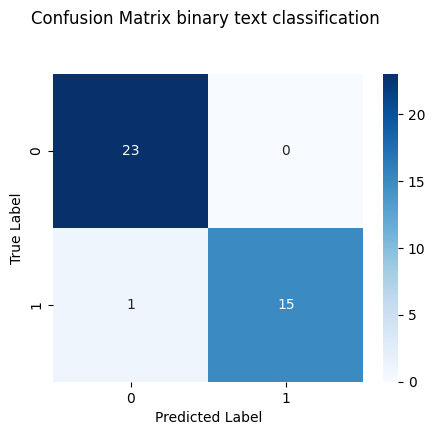

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix_classification = confusion_matrix(all_labels_classification, all_predictions_classification)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_classification, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix binary text classification \n\n')
plt.show()